# Import Packges

In [1]:
import tensorflow as tf
import cv2
import numpy as np

import warnings
import os
import random
from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')


In [2]:
# Input Image
width_img=128
hight_img=128
chanel_img=3

In [3]:
# Define the folder path
tr_path='stage1_train/'
ts_path='stage1_test/'

seed=42
random.seed=seed
np.random.seed=seed

# Get train and test ids
tr_ids=next(os.walk(tr_path))[1]
ts_ids=next(os.walk(ts_path))[1]

# Preprocessing image

In [4]:
# Creatr array with zeros of the same size as the resize image size
x_train=np.zeros((len(tr_ids), hight_img, width_img, chanel_img), dtype=np.uint8)
y_train= np.zeros((len(tr_ids), hight_img, width_img, 1), dtype= np.bool)

C:\Users\Marwan Gamal\AppData\Local\Temp\ipykernel_5724\3956398258.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train= np.zeros((len(tr_ids), hight_img, width_img, 1), dtype= np.bool)


In [5]:
# Resize train images and masks

for n, id_ in tqdm (enumerate(tr_ids), total=len(tr_ids)):
    path= tr_path + id_
    img= imread(path+ '/images/' + id_ + '.png')[:,:,:chanel_img]
    img= resize(img,(hight_img, width_img), mode='constant', preserve_range=True)
    x_train[n]=img # Filling empty x_train with values from img
    
    mask= np.zeros((hight_img, width_img, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (hight_img, width_img), mode= 'constant', preserve_range=True), axis=-1)
        mask= np.maximum(mask, mask_)
    y_train[n]= mask

  0%|                                                                                          | 0/670 [00:00<?, ?it/s]C:\Users\Marwan Gamal\AppData\Local\Temp\ipykernel_5724\726799481.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask= np.zeros((hight_img, width_img, 1), dtype=np.bool)
100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [03:44<00:00,  2.99it/s]


In [6]:
# Resize test images
x_test=np.zeros((len(ts_ids), hight_img, width_img, chanel_img),dtype=np.uint8)
sizes_test=[]

for n, id_ in tqdm (enumerate(ts_ids), total=len(ts_ids)):
    path= ts_path + id_
    img= imread(path+ '/images/' + id_ + '.png')[:,:,:chanel_img]
    sizes_test.append([img.shape[0], img.shape[1]])
    img= resize(img,(hight_img, width_img), mode='constant', preserve_range=True)
    x_test[n]=img

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 41.41it/s]


In [20]:
#imgX =random.randint(0,len(tr_ids))

#imshow(x_train[imgX])
#plt.title("IMAGE")
#plt.axis('off')
#plt.show()

#plt.title("Mask IMAGE")
#plt.axis('off')
#imshow(np.squeeze(y_train[imgX]))
#plt.show()

# Bulid U-net Model

In [8]:
Inputs=tf.keras.layers.Input((width_img,hight_img,chanel_img))
Convert=tf.keras.layers.Lambda(lambda x:x/255)(Inputs) # convert int to float

#  Contracting Path (Encoding)

In [9]:
c1= tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(Convert)
c1=tf.keras.layers.Dropout(0.1)(c1)
c1= tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1) 
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

c2= tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2=tf.keras.layers.Dropout(0.1)(c2)
c2= tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2) 
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

c3= tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3=tf.keras.layers.Dropout(0.2)(c3)
c3= tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3) 
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

c4= tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4=tf.keras.layers.Dropout(0.2)(c4)
c4= tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4) 
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

c5= tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5= tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5) 

# Expansion path (Decoding)

In [10]:
U6=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
# U6= U6 + C4
U6=tf.keras.layers.concatenate([U6,c4])
c6= tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(U6)
c6=tf.keras.layers.Dropout(0.2)(c6)
c6= tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6) 
U7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
# U7= U7 + C3
U7=tf.keras.layers.concatenate([U7,c3])
c7= tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(U7)
c7=tf.keras.layers.Dropout(0.2)(c7)
c7= tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7) 

U8=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
# U8= U8 + C2
U8=tf.keras.layers.concatenate([U8,c2])
c8= tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(U8)
c8=tf.keras.layers.Dropout(0.1)(c8)
c8= tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8) 

U9=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
# U9= U9 + C1
U9=tf.keras.layers.concatenate([U9,c1], axis=3)
c9= tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(U9)
c9=tf.keras.layers.Dropout(0.1)(c9)
c9= tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9) 

# Output Layer
output_layer=tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

In [11]:
model=tf.keras.Model(inputs=[Inputs], outputs=[output_layer])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

# Model Checkpoint

In [12]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('nucleus_Model.hdf5', verbose=1, save_best_only=True)
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),#Number of epochs with no improvement after which training will be stopped.
    tf.keras.callbacks.TensorBoard(log_dir='logs')#the path of the directory where to save the log files to be parsed by TensorBoard.
]


In [13]:
history =model.fit(x_train,y_train,validation_split=0.1, batch_size=16 ,epochs=100, callbacks=callbacks)

Epoch 1/100
38/38 [==============================] - 113s 3s/step - loss: 0.6141 - accuracy: 0.7642 - val_loss: 0.4824 - val_accuracy: 0.8162
Epoch 2/100
38/38 [==============================] - 48s 1s/step - loss: 0.3847 - accuracy: 0.8062 - val_loss: 0.2356 - val_accuracy: 0.8544
Epoch 3/100
38/38 [==============================] - 48s 1s/step - loss: 0.2297 - accuracy: 0.8897 - val_loss: 0.1686 - val_accuracy: 0.9380
Epoch 4/100
38/38 [==============================] - 48s 1s/step - loss: 0.1698 - accuracy: 0.9391 - val_loss: 0.1423 - val_accuracy: 0.9458
Epoch 5/100
38/38 [==============================] - 48s 1s/step - loss: 0.1299 - accuracy: 0.9496 - val_loss: 0.1113 - val_accuracy: 0.9554
Epoch 6/100
38/38 [==============================] - 48s 1s/step - loss: 0.1225 - accuracy: 0.9524 - val_loss: 0.1349 - val_accuracy: 0.9561
Epoch 7/100
38/38 [==============================] - 48s 1s/step - loss: 0.1188 - accuracy: 0.9538 - val_loss: 0.1204 - val_accuracy: 0.9549
Epoch 8/100


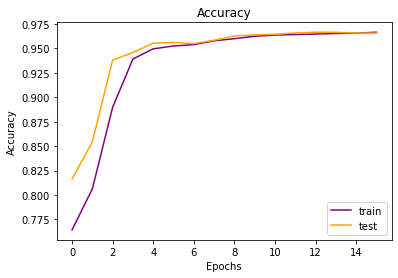

In [14]:
plt.plot(history.history["accuracy"],c = "purple")
plt.plot(history.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show();

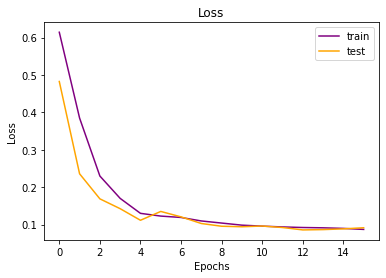

In [15]:
plt.plot(history.history["loss"],c = "purple")
plt.plot(history.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show();

In [16]:
idx= random.randint(0,len(x_train))
prd_train=model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
prd_val=model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
prd_test=model.predict(x_test, verbose=1)

3/3 [==============================] - 6s 3s/step


In [17]:
# Each pixel is given a value between 0 & 1. we set a threshold 0.5 to binarize. Threshold prediction to binarize the image  
preds_train= (prd_train>0.5).astype(np.uint8)
preds_val= (prd_val>0.5).astype(np.uint8)
preds_test= (prd_test>0.5).astype(np.uint8)

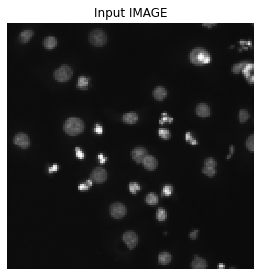

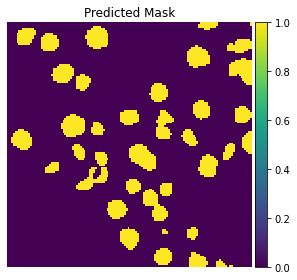

In [19]:
ix =random.randint(0,len(preds_train))
imshow(x_train[ix])
plt.title("Input IMAGE")
plt.axis('off')
plt.show();

#plt.title("Mask IMAGE")
#plt.axis('off')
#imshow(np.squeeze(y_train[ix]))
#plt.show()

plt.title("Predicted Mask")
plt.axis('off')
imshow(np.squeeze(preds_train[ix]))
plt.show();